## Rebuild the parametrized circuit in AWS Braket

In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector

from braket.devices import LocalSimulator
from braket.circuits import Circuit, Gate, Instruction, QubitSet, AngledGate, Observable
from braket.circuits import noises
from braket.circuits.gates import X, Rx, Rz, CNot, XY, PulseGate, U
from braket.quantum_information import PauliString
from braket.parametric import FreeParameter, FreeParameterExpression

from qiskit_braket_provider.providers import adapter


In [2]:
action_vector = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]) # np.random.uniform(-np.pi, np.pi, 7)

In [3]:
q_reg = QuantumRegister(2)
baseline = np.pi * np.zeros(len(action_vector))
params = ParameterVector("a", 7)
qiskit_circuit = QuantumCircuit(q_reg, name="custom_cx")
# optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
optimal_params = np.pi * np.zeros(7)

qiskit_circuit.u(
    baseline[0] + params[0],
    baseline[1] + params[1],
    baseline[2] + params[2],
    q_reg[0],
)
qiskit_circuit.u(
    baseline[3] + params[3],
    baseline[4] + params[4],
    baseline[5] + params[5],
    q_reg[1],
)

qiskit_circuit.rzx(baseline[6] + params[6], q_reg[0], q_reg[1])

braket_circuit_converted = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)

print(braket_circuit_converted)

T  : |     0     |   1    |     2     |3|4|   5    |6|7|
                                                        
q0 : -PHASE(a[2])-Ry(a[0])-PHASE(a[1])---C----------C---
                                         |          |   
q1 : -PHASE(a[5])-Ry(a[3])-PHASE(a[4])-H-X-Rz(a[6])-X-H-

T  : |     0     |   1    |     2     |3|4|   5    |6|7|

Unassigned parameters: [a[0], a[1], a[2], a[3], a[4], a[5], a[6]].


#### Braket Version

In [4]:
braket_circuit = Circuit()

baseline = np.pi * np.zeros(len(action_vector))
params = [FreeParameter(f"a{i}") for i in range(0, len(action_vector))]

u1 = U(
    baseline[0] + params[0], 
    baseline[1] + params[1], 
    baseline[1] + params[2],
)
u2 = U(
    baseline[3] + params[3], 
    baseline[4] + params[4], 
    baseline[5] + params[5],
)

# rzx = RZX(
#     baseline[6] + params[6]
# )

braket_circuit.add_instruction(Instruction(u1, [0]))
braket_circuit.add_instruction(Instruction(u2, [1]))
print(braket_circuit)

T  : |      0      |
                    
q0 : -U(a0, a1, a2)-
                    
q1 : -U(a3, a4, a5)-

T  : |      0      |

Unassigned parameters: [a0, a1, a2, a3, a4, a5].


In [5]:
def rzx(theta, register):
    """
    RZX gate decomposition for angle theta
    """
    q1, q2 = register
    qc = Circuit()

    # Step 1: Apply Hadamard gate to the target qubit
    qc.h(q2)

    # Step 2: Apply CNOT gate with q1 as control and q2 as target
    qc.cnot(q1, q2)

    # Step 3: Apply RZ gate with angle theta to the target qubit
    # Since Braket's RZ gate uses full angle, there's no need to divide theta by 2
    qc.rz(q2, angle=theta)

    # Step 4: Apply another CNOT gate with q1 as control and q2 as target
    qc.cnot(q1, q2)

    # Step 5: Apply Hadamard gate to the target qubit again
    qc.h(q2)
    
    return qc

Circuit.register_subroutine(rzx)

braket_circuit.rzx(baseline[6] + params[6], [0, 1])

print(braket_circuit)

T  : |      0      |1|2|  3   |4|5|
                                   
q0 : -U(a0, a1, a2)---C--------C---
                      |        |   
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-

T  : |      0      |1|2|  3   |4|5|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


Sanity Checks if RZX was correclty implemented

In [6]:
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

new_circ = Circuit()
check1 = np.isclose(new_circ.rzx(0, [0, 1]).to_unitary(), np.eye(4), atol=1e-8)
new_circ = Circuit()
check2 = np.isclose(new_circ.rzx(2*np.pi, [0, 1]).to_unitary(), -np.eye(4), atol=1e-8)
new_circ = Circuit()
check3 = np.isclose(new_circ.rzx(np.pi, [0, 1]).to_unitary(), -1j * np.kron(Z, X), atol=1e-8)

if check1.all() and check2.all() and check3.all():
    print("RZX gate is implemented correctly!")

RZX gate is implemented correctly!


In [7]:
device = LocalSimulator() # Noise-Free statevector simulation
# device = LocalSimulator(backend="braket_dm") # For simulations with noise

In [8]:
param_names = [str(param) for param in params]
bound_parameters = dict(zip(param_names, action_vector))

In [9]:
print('Braket Circuit: \n\n', braket_circuit)
print('\n\nQiskit to Braket Circuit Conversion: \n\n', braket_circuit_converted)

Braket Circuit: 

 T  : |      0      |1|2|  3   |4|5|
                                   
q0 : -U(a0, a1, a2)---C--------C---
                      |        |   
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-

T  : |      0      |1|2|  3   |4|5|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


Qiskit to Braket Circuit Conversion: 

 T  : |     0     |   1    |     2     |3|4|   5    |6|7|
                                                        
q0 : -PHASE(a[2])-Ry(a[0])-PHASE(a[1])---C----------C---
                                         |          |   
q1 : -PHASE(a[5])-Ry(a[3])-PHASE(a[4])-H-X-Rz(a[6])-X-H-

T  : |     0     |   1    |     2     |3|4|   5    |6|7|

Unassigned parameters: [a[0], a[1], a[2], a[3], a[4], a[5], a[6]].


In [10]:
n_shots = 1000

In [11]:
# run the circuit on the local simulator
task = device.run(braket_circuit, shots=n_shots, inputs=bound_parameters)

# visualize the results
result = task.result()
measurement = result.measurement_counts
print('measurement results:', measurement)

measurement results: Counter({'00': 1000})


### Measuring expectation values

In [12]:
observable_string_xx = "XX"
observable_string_zz = "ZZ"

In [13]:
PauliString(observable_string_xx).to_unsigned_observable() + PauliString(observable_string_zz).to_unsigned_observable()

Sum(TensorProduct(X('qubit_count': 1), X('qubit_count': 1)), TensorProduct(Z('qubit_count': 1), Z('qubit_count': 1)))

In [14]:
pauli_operator = 0.5 * PauliString(observable_string_xx).to_unsigned_observable() + 0.5 * PauliString(observable_string_zz).to_unsigned_observable()

In [15]:
list(pauli_operator.summands)[0].coefficient

0.5

Measure expectation values on the native braket circuit

In [16]:
# Create a small circuit with a free parameter theta
pauli_string = PauliString(observable_string_xx)
pauli_operator = pauli_string.to_unsigned_observable()

braket_circuit.state_vector() # Get the state vector of the circuit
braket_circuit.expectation(observable=pauli_operator, target=[0, 1]) # Get the expectation value of the Pauli operator

# pauli_string = PauliString(observable_string_xx)
# pauli_operator = 0.5*pauli_string.to_unsigned_observable()
# braket_circuit.expectation(observable=pauli_operator, target=[0, 1]) 
print(braket_circuit)

# Small value for test purposes
# batchsize = 5
# batch_circuits = [circ] * batchsize

T  : |      0      |1|2|  3   |4|5|  Result Types  |
                                                    
q0 : -U(a0, a1, a2)---C--------C---Expectation(X@X)-
                      |        |   |                
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-Expectation(X@X)-

T  : |      0      |1|2|  3   |4|5|  Result Types  |

Additional result types: StateVector

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


In [17]:
job = device.run(braket_circuit, shots=0, inputs=bound_parameters)

# Run multiple circuits at once
# job = device.run_batch(
#     batch_circuits,
#     inputs={'theta': thetas}, 
#     shots=100
# )

print('Measurement Counts:', job.result().measurement_counts)
print('Measurement Probabilities:', job.result().measurement_probabilities)

print("Final EXACT state vector:\n", job.result().values[0])
print(f"Expectation value <{observable_string_xx}>:", np.round(job.result().values[1], 5))

Measurement Counts: None
Measurement Probabilities: None
Final EXACT state vector:
 [1.00000000e+00+3.92523115e-17j 5.61334798e-17-6.73463194e-18j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
Expectation value <XX>: 0.0


Run same circuit with Qiskit Estimator

In [18]:
from qiskit.primitives import Estimator
from qiskit.quantum_info.operators import SparsePauliOp

estimator = Estimator()
observable = SparsePauliOp(
    [observable_string_xx], #, observable_string_xx], 
    coeffs=[1] # , 0.5]
)

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


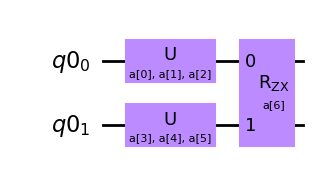

In [19]:
qiskit_circuit.draw('mpl')

In [23]:
qiskit_job = estimator.run(
    circuits=qiskit_circuit, 
    observables=observable, 
    parameter_values=action_vector,
    shots=n_shots
)

In [24]:
def create_expectation_string(prefactors, observable_strings):
    if len(prefactors) != len(observable_strings):
        raise ValueError("The lengths of prefactors and observable_strings should be the same.")

    expectation_string = "Expectation value "
    for i in range(len(prefactors)):
        expectation_string += f"{prefactors[i]}*<{observable_strings[i]}>"
        if i < len(prefactors) - 1:
            expectation_string += " + "

    expectation_string += ":"

    return expectation_string

In [25]:
print(create_expectation_string(observable.coeffs, observable.settings['data']), qiskit_job.result().values)

Expectation value (1+0j)*<XX>: [0.0185983]
